In [1]:
import os
os.chdir("..")
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from src.amortized_inference.config import default_config
from src.amortized_inference.dataset import UserDataset
from src.amortized_inference.raycasting_trainer import RaycastingTrainer
from src.amortized_inference.raycasting_supervised_trainer import RaycastingSupervisedTrainer

human_trainers = [list(), list()]
sim_trainers = list()

for dense_grid in [0, 1]:
  # k-fold trained models
  for k in [1, 2, 3, 4, 5]:
    config_temp = deepcopy(default_config)
    config_temp["n_train_user"] = -1
    config_temp["n_trial_per_user"] = -1
    config_temp["cross_fold_idx"] = k
    config_temp["dense_grid"] = dense_grid
    config_temp["amortizer"]["encoder"]["stat_sz"] = (1 + 3*25 + 3*30) if dense_grid == 1 else (1 + 3*26 + 3*30)

    name = "dense" if dense_grid else "wide"
    name += f"_{config_temp['cross_fold_idx']}"
    config_temp["name"] = "human_" + name

    tr = RaycastingSupervisedTrainer(config=config_temp)
    tr.load()
    tr.amortizer.eval()
    human_trainers[dense_grid].append(tr)

  config_temp["cross_fold_idx"] = -1
  config_temp["simulator"]["small_target"] = -1
  config_temp["simulator"]["dense_grid"] = dense_grid

  name = "dense" if dense_grid else "wide"
  config_temp["name"] = "sim_" + name
  sim_tr = RaycastingTrainer(config=config_temp)
  sim_tr.load()
  sim_tr.amortizer.eval()
  sim_trainers.append(sim_tr)
  
user_dataset = UserDataset()

objects_pos_grid = list()
for dense_grid in [0, 1]:
  n_row, n_column = [7, 7] if dense_grid else [7, 9]
  spacing = 1.44 if dense_grid else 6.0
  target_dist = 5.0

  n_obj = n_row * n_column
  objects_pos = list()

  for obj_i in range(1, n_obj+1):
      row = (obj_i-1) // n_column
      column = (obj_i-1) % n_column
      phi = -(column - (n_column-1)/2) * spacing * math.pi / 180.0 # azimuth angle
      theta = -(row - (n_row-1)/2) * spacing * math.pi / 180.0 # elevation angle

      depth = target_dist * math.cos(theta) * math.cos(phi)
      x = target_dist * math.cos(theta) * math.sin(phi)
      y = target_dist * math.sin(theta)
      obj_pos = np.array([depth, x, y])

      objects_pos.append(obj_pos * np.array([1, -1, 1]))
  objects_pos_grid.append(np.array(objects_pos) + np.array([0.0, 0.0, 1.2]))

[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_1/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_2/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_3/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_4/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_5/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/sim_wide/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_1/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inf

In [2]:
# Functions for Quadratic Regression
from scipy.optimize import fsolve, minimize
index_values = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

def get_dis_velocity(arr):
    vel = [0]
    dis = [0]
    total_dis = 0
    for i in range(len(arr) - 1):
        this_vel = np.linalg.norm(arr[i + 1] - arr[i])
        vel.append(this_vel)
        total_dis = total_dis + abs(this_vel)
        dis.append(total_dis)
    return dis, vel

def get_predicted_distance(cursor_positions):
    traj_dis, traj_vel = get_dis_velocity(cursor_positions)
    coefficients = np.polyfit(traj_dis, traj_vel, 2)  # 3-degree polynomial

    # Create a polynomial object
    polynomial = np.poly1d(coefficients)

    def find_zero_crossing(x):
        return polynomial(x)

    zero_crossings = fsolve(find_zero_crossing, x0=2.5)  # Starting guess for the root
    return zero_crossings[0]

def get_actual_distance(cursor_positions):
    traj_dis, traj_vel = get_dis_velocity(cursor_positions)
    total_distance = traj_dis[-1]
    return total_distance

def get_multiply_coefficient(predicted_distances, actual_distance):
    all_coefficient = []
    for predicted_distance in predicted_distances:
        def objective_function(s):
            return np.sum(np.abs(predicted_distance * s - actual_distance))
        initial_s = 1.0
        result = minimize(objective_function, initial_s, method='BFGS')
        optimized_s = result.x[0]
        all_coefficient.append(optimized_s)
    all_coefficient = np.array(all_coefficient)
    return all_coefficient

def get_unit_vector(position1, position2):
    vector = position2 - position1

    # Calculate the length (magnitude) of the vector
    vector_length = np.linalg.norm(vector)

    # Normalize the vector to get the unit vector
    unit_vector = vector / vector_length
    return unit_vector

def interpolate_2d_lookup_table(index_values, value_table, target_index):
    # Ensure that the target index is within the range of the provided index values
    if target_index < index_values[0]:
        target_index = index_values[0]
        lower_idx = 0
    elif target_index > index_values[-1]:
        target_index = index_values[-1]
        lower_idx = len(index_values) - 2
    else:
        # Find the nearest indices for interpolation
        lower_idx = np.searchsorted(index_values, target_index) - 2

    upper_idx = lower_idx + 1
    
    # Calculate the weights for interpolation
    lower_weight = (index_values[upper_idx] - target_index) / (index_values[upper_idx] - index_values[lower_idx])
    upper_weight = 1 - lower_weight
    
    # Perform linear interpolation
    predicted_value = lower_weight * value_table[lower_idx] + upper_weight * value_table[upper_idx]
    return predicted_value

def get_predicted_position_coe_corrected(cursor_positions, index_values, value_table):
    traj_dis, traj_vel = get_dis_velocity(cursor_positions)
    coefficients = np.polyfit(traj_dis, traj_vel, 2)  # 3-degree polynomial

    # Create a polynomial object
    polynomial = np.poly1d(coefficients)

    def find_zero_crossing(x):
        return polynomial(x)

    zero_crossings = fsolve(find_zero_crossing, x0=2.5)  # Starting guess for the root
    
    predicted_distance = zero_crossings[0]
    percentage = traj_dis[-1] / predicted_distance
    multiplication_coefficient = interpolate_2d_lookup_table(index_values, value_table, percentage)
    predicted_distance_after_correction = predicted_distance * multiplication_coefficient
    
    future_distance = predicted_distance_after_correction - traj_dis[-1]
    vector = get_unit_vector(cursor_positions[0], cursor_positions[-1])
    final_position = cursor_positions[-1] + vector * future_distance
    return final_position

In [3]:
# Get Quadratic Regression's coefficients
progress_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
coeff_table = np.zeros((2, 5, len(progress_list)))

for dense_grid in [0, 1]:
    for k in [1, 2, 3, 4, 5]:

        all_pred_distances = list()
        for progress in progress_list:
            # training data
            train_users = list()
            all_users = np.arange(1, 21)
            fold_sz = 4
            for i in [1, 2, 3, 4, 5]:
                if k != i:
                    train_users.extend(all_users[(k-1)*fold_sz:k*fold_sz])
            
            gt_targets, gt_summ_data, gt_traj_data = \
                user_dataset.sample(fix_progress=progress, user_list=train_users, dense_grid=dense_grid, small_target=-1)
            
            n_trials = gt_targets.shape[0]
            pred_distances = list()
            stride = 5
            for trial_i in range(0, n_trials, stride):
                summ_i, traj_i = gt_summ_data[trial_i], gt_traj_data[trial_i]
                cursor_pos = (traj_i[:, 6:9] + 1) / 2 * (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, 0.0])) + np.array([4.5, -1.6, 0.0])
                if progress < 1.0:
                    pred_distances.append(get_predicted_distance(cursor_pos))
                else:
                    pred_distances.append(get_actual_distance(cursor_pos))

            all_pred_distances.append(pred_distances)
        all_pred_distances = np.array(all_pred_distances)
        coeff = get_multiply_coefficient(all_pred_distances, all_pred_distances[-1])
        coeff_table[dense_grid, k-1, :] = coeff

print(coeff_table)

[[[1.40263659 1.17741419 1.14190022 1.12325242 1.09995197 1.07761893
   1.05953239 1.0448751  1.        ]
  [1.41771696 1.15619869 1.13871378 1.11448942 1.09124584 1.07011368
   1.05343766 1.04099014 1.        ]
  [1.80026859 1.2251937  1.13522745 1.11669414 1.10028383 1.07698263
   1.05705405 1.04000517 1.        ]
  [1.47704486 1.22973035 1.16892573 1.13595964 1.11219779 1.08693569
   1.06483447 1.04647441 1.        ]
  [1.48686862 1.19073652 1.14097249 1.11783878 1.09150195 1.07054962
   1.05259126 1.03914139 1.        ]]

 [[1.36777305 1.09995425 1.06683728 1.07258287 1.07063869 1.05758305
   1.04622076 1.03458402 1.        ]
  [1.37240008 1.04359306 1.06579296 1.08221231 1.07255537 1.05950736
   1.04685412 1.03578198 1.        ]
  [1.53540077 1.10612774 1.07174085 1.08966429 1.08028802 1.06411027
   1.0486526  1.03510772 1.        ]
  [1.33414574 1.10561629 1.10128994 1.09361052 1.08374131 1.06736611
   1.05204007 1.03829054 1.        ]
  [1.41613544 1.01408359 1.08695185 1.087135

In [4]:
import time
from tqdm import tqdm

def get_closest_target(cursor_pos, objects_pos):
    # Compute the Euclidean distance between cursor_pos and all objects in objects_pos
    distances = np.linalg.norm(objects_pos - cursor_pos, axis=1)
    # Get the index of the closest object
    closest_idx = np.argmin(distances)
    # Get the position of the closest object
    closest_pos = objects_pos[closest_idx]
    return closest_pos

progress_list = np.arange(1, 11) * 0.1 # the fraction of trajcetory observed

acc_arr = np.zeros((len(progress_list), 2, 5, 4))
time_arr = np.zeros((len(progress_list), 2, 5, 4))
conf_arr = np.zeros((len(progress_list), 2, 5, 2))

for progress_i, progress in tqdm(enumerate(progress_list)):
    for dense_grid in [0, 1]:
        for k in [1, 2, 3, 4, 5]:
            fold_sz = 4
            all_users = np.arange(1, 21)
            valid_users = all_users[(k-1)*fold_sz:k*fold_sz]

            gt_targets, gt_summ_data, gt_traj_data = \
                user_dataset.sample(fix_progress=progress, user_list=valid_users, dense_grid=dense_grid, small_target=-1)
            
            n_trials = gt_targets.shape[0]
            stride = 10
            acc = [list(), list(), list(), list()]
            elapsed_t = [list(), list(), list(), list()]
            conf = [list(), list()]

            for trial_i in range(0, n_trials, stride):
                target_i, summ_i, traj_i = gt_targets[trial_i], gt_summ_data[trial_i], gt_traj_data[trial_i]

                # All targets' true 3-d location
                target_pos = (target_i + 1) / 2 * (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, -1.6])) + np.array([4.5, -1.6, -1.6]) + \
                    + np.array([0.0, 0.0, 1.2])
                cursor_pos = (traj_i[:, 6:9] + 1) / 2 * (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, 0.0])) + np.array([4.5, -1.6, 0.0])
                
                objects_norm = ((objects_pos_grid[dense_grid] - np.array([0.0, 0.0, 1.2])) - np.array([4.5, -1.6, -1.6])) / (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, -1.6]))
                objects_norm = 2 * objects_norm - 1

                #### Baseline 1: Nearest Neighbor

                time_start = time.time()
                proximity_res = get_closest_target(cursor_pos[-1], objects_pos=objects_pos_grid[dense_grid])
                elapsed_t[0].append((time.time() - time_start)*1000)
                acc[0].append(np.allclose(proximity_res, target_pos, atol=1e-3))

                #### Baseline 2: Quadratic Regression

                time_start = time.time()
                if len(cursor_pos) < 3:
                    quad_pred_res = get_closest_target(cursor_pos[-1], objects_pos=objects_pos_grid[dense_grid])
                else:
                    quad_pred_res = get_predicted_position_coe_corrected(
                        cursor_pos,
                        index_values,
                        coeff_table[int(dense_grid), k-1, :]
                    )
                    quad_pred_res = get_closest_target(quad_pred_res, objects_pos=objects_pos_grid[dense_grid])
                elapsed_t[1].append((time.time() - time_start)*1000)
                acc[1].append(np.allclose(quad_pred_res, target_pos, atol=1e-3))

                #### Baseline 3: Human-data-based SL

                time_start = time.time()
                adjusted_summ = np.concatenate((
                    summ_i,
                    np.array(user_dataset.adjust_traj_length(traj_i[:, 6:9]), dtype=np.float64).reshape((-1,))
                ), axis=-1)
                summs = np.expand_dims(adjusted_summ, axis=0)
                summs = np.repeat(summs, objects_norm.shape[0], axis=0)

                densities = human_trainers[dense_grid][k-1].amortizer.pdf(objects_norm, summs) + 1e-30
                probabilities = densities / np.nansum(densities)
                max_target_i = np.argmax(probabilities)

                elapsed_t[2].append((time.time() - time_start)*1000)
                acc[2].append(np.allclose(objects_pos_grid[dense_grid][max_target_i], target_pos, atol=1e-3))
                conf[0].append(probabilities[max_target_i])

                #### Baseline 4: Simulation-based SL
                
                time_start = time.time()
                densities = sim_trainers[dense_grid].amortizer.pdf(objects_norm, summs) + 1e-30
                probabilities = densities / np.nansum(densities)
                max_target_i = np.argmax(probabilities)

                elapsed_t[3].append((time.time() - time_start)*1000)
                acc[3].append(np.allclose(objects_pos_grid[dense_grid][max_target_i], target_pos, atol=1e-3))
                conf[1].append(probabilities[max_target_i])

            acc_arr[progress_i, dense_grid, k-1] = (np.array(acc).mean(axis=-1))
            time_arr[progress_i, dense_grid, k-1] = (np.array(elapsed_t).mean(axis=-1))
            conf_arr[progress_i, dense_grid, k-1] = (np.array(conf).mean(axis=-1))

    # print(f"progress: {progress_i}", acc_arr[progress_i].mean(axis=(1)))

10it [07:39, 45.99s/it]


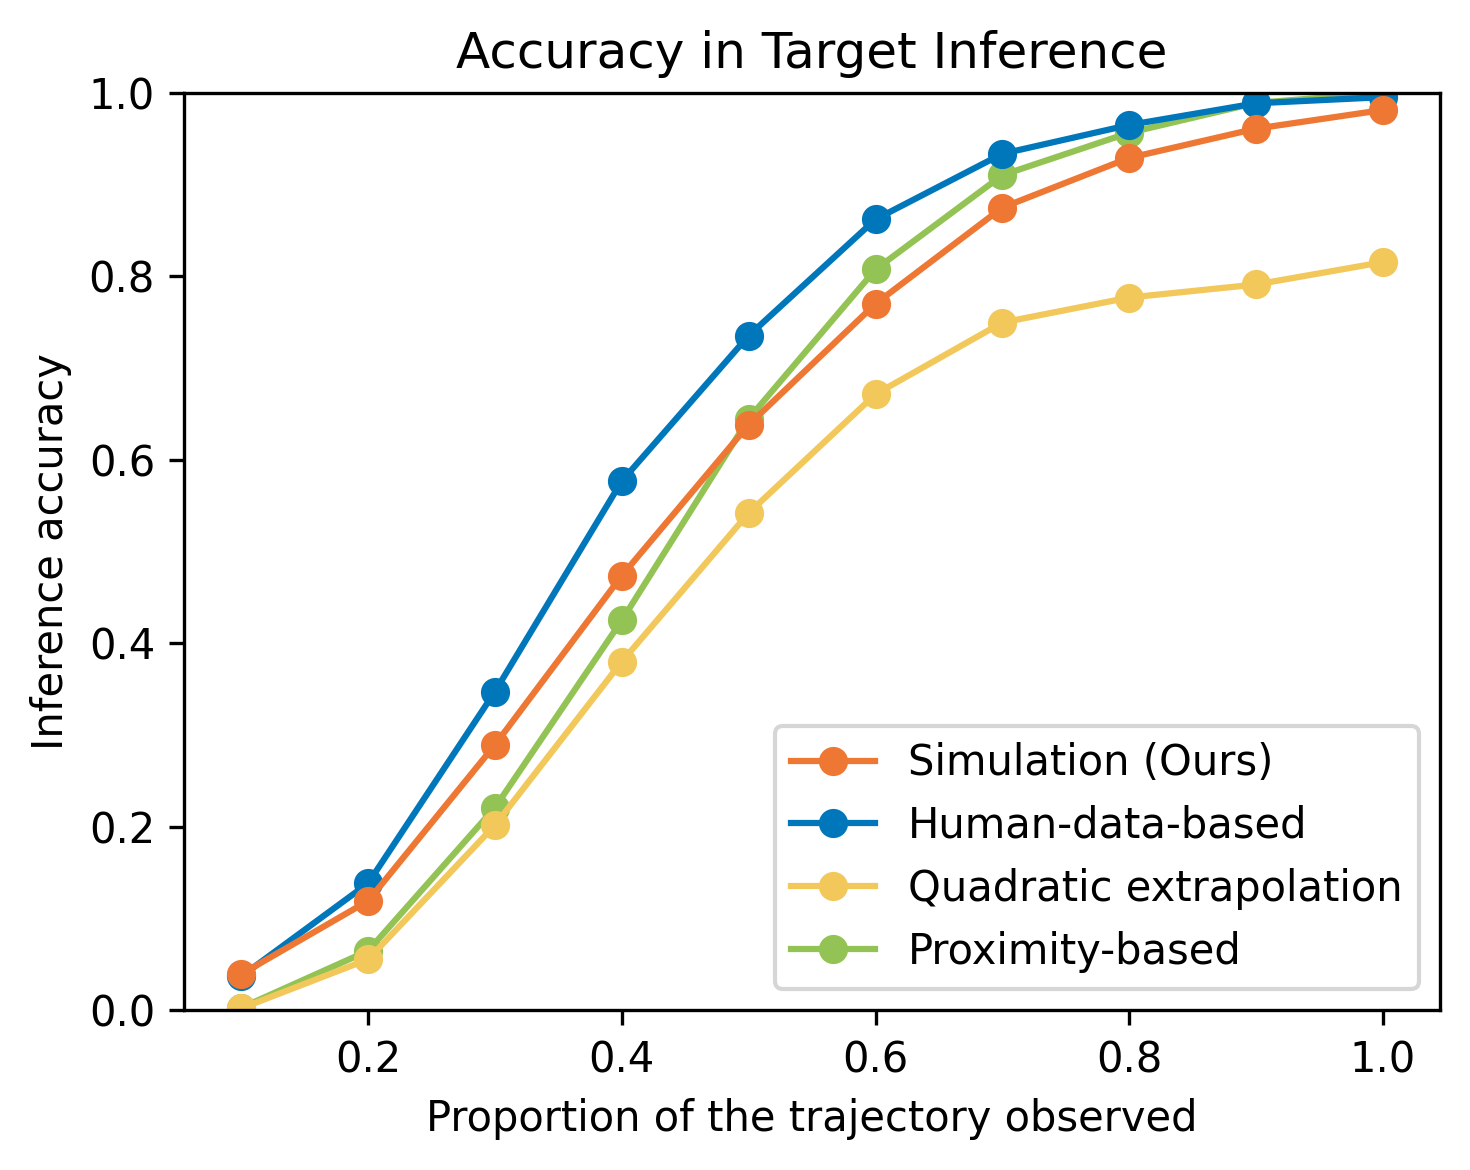

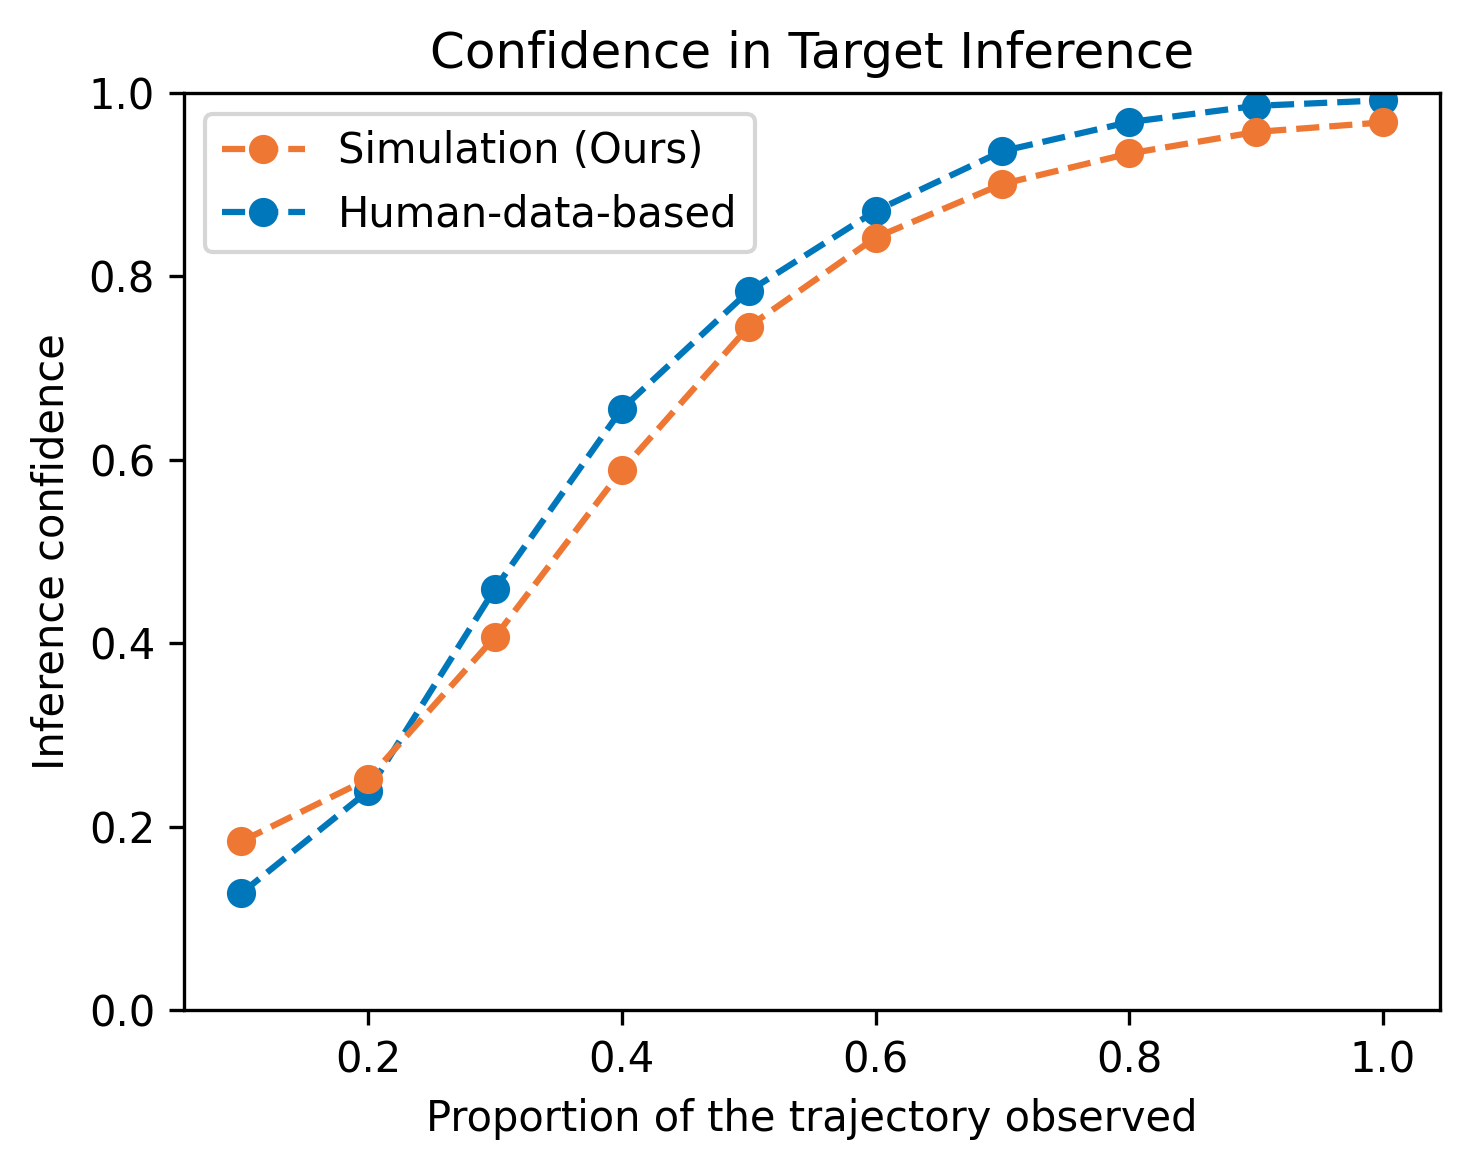

In [6]:
# Figure 8: Inference results per trajectory proportion

# Inference accuracy
fig = plt.figure(figsize=(5, 4), dpi=300)
x = np.arange(0.1, 1.1, 0.1)
y1 = np.array(acc_arr.mean(axis=(1, 2))[:, 0])
y2 = np.array(acc_arr.mean(axis=(1, 2))[:, 1])
y3 = np.array(acc_arr.mean(axis=(1, 2))[:, 2])
y4 = np.array(acc_arr.mean(axis=(1, 2))[:, 3])

plt.plot(x, y1, marker="o", color="#93C354", label="Proximity-based")
plt.plot(x, y2, marker="o", color="#F2C85B", label="Quadratic extrapolation")
plt.plot(x, y3, marker="o", color="#0077BB", label="Human-data-based")
plt.plot(x, y4, marker="o", color="#EE7733", label="Simulation (Ours)")

# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [3, 2, 1, 0]

# add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.ylabel("Inference accuracy")
plt.xlabel("Proportion of the trajectory observed")
plt.ylim([0.0, 1.0])
plt.title("Accuracy in Target Inference")
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study2_inference_accuracy.pdf"), dpi=300)
plt.show()
plt.close(fig)

# Inference confidence
fig = plt.figure(figsize=(5, 4), dpi=300)
x = np.arange(0.1, 1.1, 0.1)
y1 = np.array(conf_arr.mean(axis=(1, 2))[:, 0])
y2 = np.array(conf_arr.mean(axis=(1, 2))[:, 1])

plt.plot(x, y1, marker="o", color="#0077BB", label="Human-data-based", linestyle="--")
plt.plot(x, y2, marker="o", color="#EE7733", label="Simulation (Ours)", linestyle="--")

# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [1, 0]

# add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.ylabel("Inference confidence")
plt.xlabel("Proportion of the trajectory observed")
plt.ylim([0.0, 1.0])
plt.title("Confidence in Target Inference")
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study2_inference_confidence.pdf"), dpi=300)
plt.show()
plt.close(fig)